In [9]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../code/python')
from mpl_settings_v3 import *
from methods import simple_bump, square_bump, solver, D_2_per, D_4_per, D_6_per, D2_4_per, energy

In [10]:
c0 = 1
power = 4

h = 0.005
X = np.arange(0, 1+h, h)

x0 = 0.25
x1 = 0.75
simple = np.array([simple_bump(x, x0, x1, power, c0) for x in X])

x0 = 0.25
x1 = 0.35
x2 = 0.65
x3 = 0.75
square = np.array([square_bump(x, x0, x1, x2, x3, power, c0) for x in X])

Nx = X.size
print('Nx =', Nx)

Nx = 201


In [20]:
def solver(f, k, h, ti, tf, x0, samples='all', method='RK4', verbose=False):
       
    Nt = round((tf - ti) / k) + 1
    print(Nt)
    grid = np.arange(0, 1+h, h)
        
    x = x0
    data = [x]
    time = [ti]
    t = ti + k
    #for i, t in enumerate(time[1:], start=1):
    i = 1
    while t <= tf:

        if method == 'euler':
            x = x + k * f(x, t)
        elif method == 'RK4':
            q1 = f(x, t)
            q2 = f(x + (k/2)*q1, t+(k/2))
            q3 = f(x + (k/2)*q2, t+(k/2))
            q4 = f(x + k*q3, t+k)
            x = x + (k/6)*(q1 + 2*q2 + 2*q3 + q4) 
        
        #if samples == 'all' or ((samples*i) % (Nt-1)) == 0:
        if samples == 'all' or ((samples*i) % (Nt-1)) == 0:
            if verbose:
                print('{:2f}'.format(t))
            time.append(t)
            data.append(x)
        i += 1
        t += k
    
    time = np.array(time)
    data = np.array(data)
    assert(time.size*grid.size == data.size)
    return time, grid, data

v = -1
#k = 0.0001
k = 0.0001
ti = 0
T = 10
C = np.abs(v*k/h)

Dx_dict = {
    'D2': (D_2_per, D2_4_per),
    #'D4': D_4_per,
    #'D6': D_6_per
}
overwrite = True
bumps = ['simple', 'square']
samples = 100
sigma = 0.0001
sols = {}
for bump in bumps:
    print(bump)
    sols[bump] = {}
    if bump == 'simple':
        x0 = simple
    else:
        x0 = square
    for key, (Dx, D2x) in Dx_dict.items():

        pickle_file = 'data/{}_k{}_h{}_T{}_samples{}_sigma{}_{}.pickle'.format(
            bump, k, h, T, samples, sigma, key
        )

        print(key)
        func = lambda x, t: v*Dx(x, h) + sigma*D2x(x, h)
        if os.path.isfile(pickle_file) and not overwrite:
            data = pickle.load(open(pickle_file, 'rb'))
            time, grid, sol = data
        else:
            time, grid, sol = solver(func, k, h, ti, T, x0, samples=samples, method='euler', verbose=False)
            pickle.dump([time, grid, sol], open(pickle_file, 'wb'))
        sols[bump][key] = sol
    
Nx = grid.size
Nt = time.size

print('CFL =', C)
print('Nx =', Nx)
print('Nt =', Nt)
print('sol shape =', sol.shape)
print('time[-1] =', time[-1])
print('time[-2] =', time[-2])

simple
D2
100001
square
D2
100001
CFL = 0.02
Nx = 201
Nt = 101
sol shape = (101, 201)
time[-1] = 9.999999999990033
time[-2] = 9.899999999990266


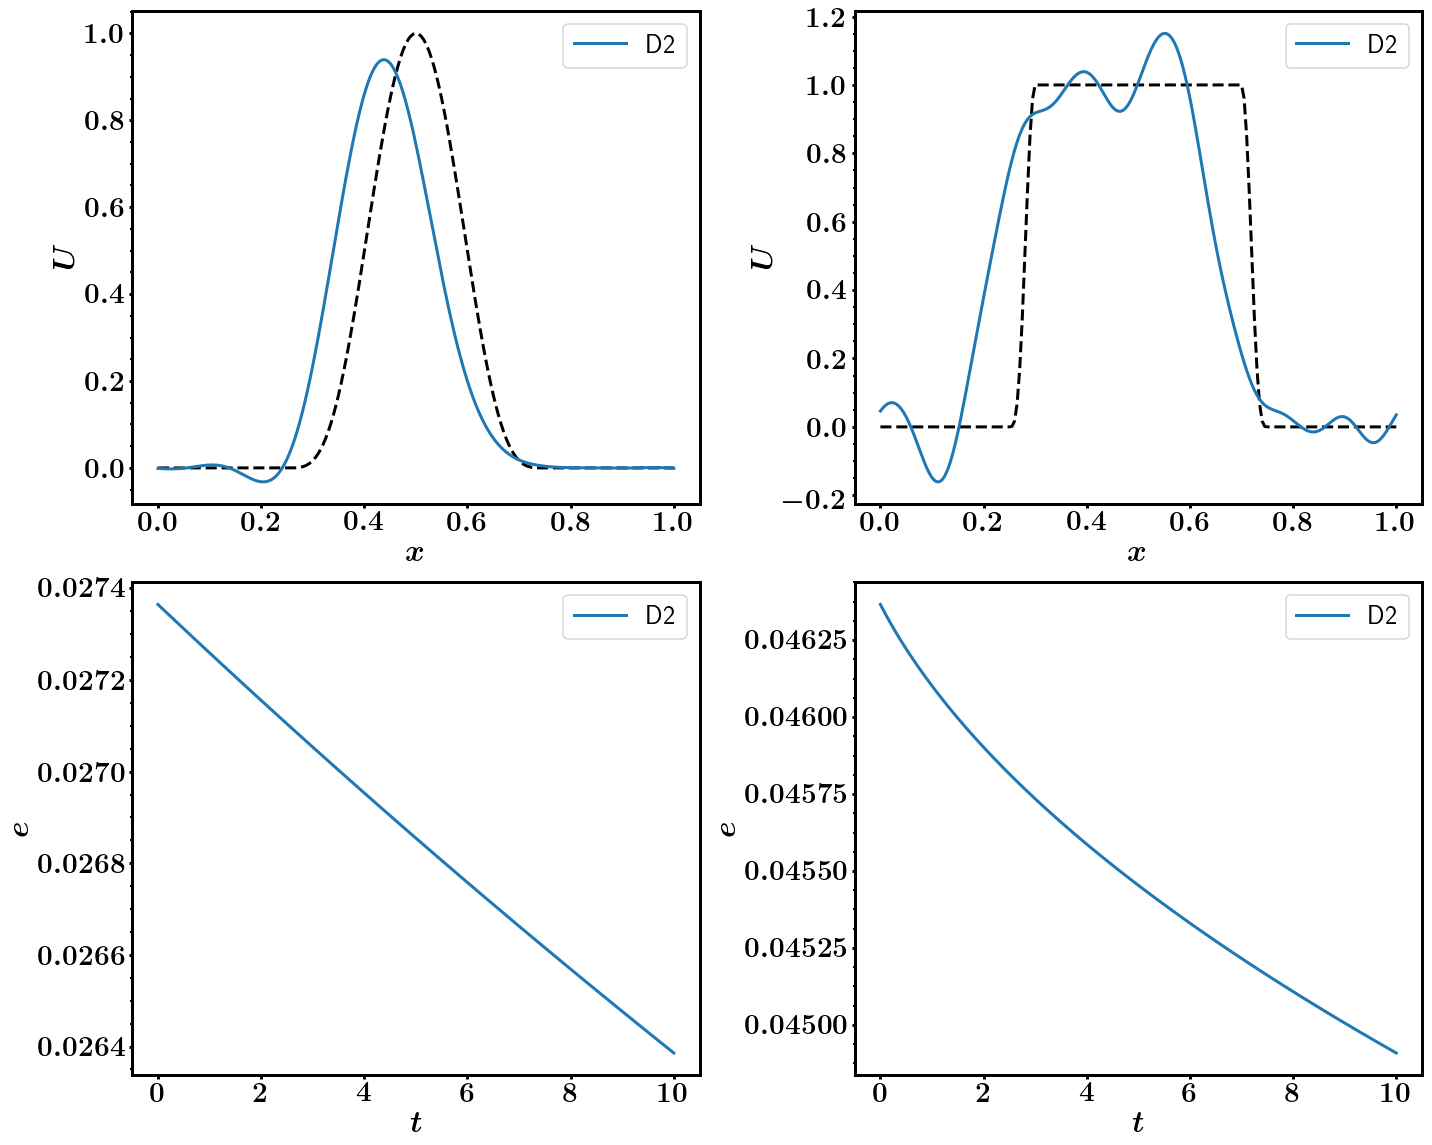

In [21]:
linestyles = ['-', '-.', ':']
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

for ax in axes[0]:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$U$')
    
for ax in axes[1]:
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$e$')
    
ax = axes[0][0]
ax.plot(X, simple, '--', color='k')
for i, key in enumerate(Dx_dict.keys()):
    sol = sols['simple'][key]
    ax.plot(grid, sol[-1], linestyle=linestyles[i], label=key)
ax.legend()

ax = axes[0][1]
ax.plot(X, square, '--', color='k')
for i, key in enumerate(Dx_dict.keys()):
    sol = sols['square'][key]
    ax.plot(grid, sol[-1], linestyle=linestyles[i], label=key)
ax.legend()

ax = axes[1][0]
for i, key in enumerate(Dx_dict.keys()):
    sol = sols['simple'][key]
    ax.plot(time, energy(sol, h), label=key)
ax.legend()

ax = axes[1][1]
for i, key in enumerate(Dx_dict.keys()):
    sol = sols['square'][key]
    ax.plot(time, energy(sol, h), label=key)
ax.legend()

plt.tight_layout()
plt.savefig('samples{}.png'.format(samples), transparent=False)
plt.show()

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim((-0.01, 1.01))
ax.set_ylim((-0.2, 1.2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = grid
    y = sols['square']['D6'][i]
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples, interval=20, blit=True)

rc('animation', html='html5')
anim